# SVM Evaluation and Fine Tuning

## Imports

In [4]:
import seaborn           as sns
import matplotlib.pyplot as plt
import pandas            as pd
import numpy             as np
import inflection

from IPython.display      import Image
from IPython.core.display import HTML

from fast_ml.model_development import train_valid_test_split

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
import pickle

# feature selection
from boruta                    import BorutaPy
from sklearn.feature_selection import RFECV
from yellowbrick.features      import Rank1D

# modeling
from sklearn.ensemble    import RandomForestClassifier
from sklearn.ensemble    import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn             import base
from sklearn             import linear_model as lm
from sklearn             import neighbors    as nh
import                          xgboost      as xgb
from sklearn.linear_model    import LogisticRegression
from sklearn.svm             import SVC
from sklearn.dummy           import DummyClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold


# model selection
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

#metrics
import scikitplot as skplt
from   sklearn.metrics import precision_score, recall_score, accuracy_score, balanced_accuracy_score
import sklearn.metrics   as m
from sklearn import metrics

# tuning/CV
import optuna as op
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from numpy import mean
from matplotlib import pyplot

## Functions

In [5]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:85% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    
    sns.set()
    
jupyter_settings()

In [7]:
def scores(model_name, y_true, y_pred):
    
    accuracy = m.balanced_accuracy_score(y_true, y_pred)
    precision = m.precision_score(y_true, y_pred)
    recall = m.recall_score(y_true, y_pred)
    f1 = m.f1_score(y_true, y_pred)
    kappa = m.cohen_kappa_score(y_true, y_pred)
    
    return pd.DataFrame({'Balanced Accuracy': np.round(accuracy, 3), 
                         'Precision': np.round(precision, 3), 
                         'Recall': np.round(recall, 3),
                         'F1': np.round(f1, 3),
                         'Kappa': np.round(kappa, 3)}, index=[model_name])

In [8]:
def precision_at_k( data, k = 100 ):
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']



def recall_at_k( data, k = 100 ):
    # reset index
    data = data.reset_index( drop = True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']


    
def cross_validation(model, x_train, y_train, k, data, Verbose = True):
    
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=28)
    precision_list = []
    recall_list = []
    precision_k_list = []
    recall_k_list = []
    balanced_list = []
    i=1

    for train_cv, val_cv in kfold.split(x_train, y_train):
        
        if Verbose == True:
            
            print(f'Fold Number {i}/{k}')
            
        else:
            pass
        
        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]
        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]

        model_fit = model.fit(x_train_fold, y_train_fold.values.ravel())
        yhat = model.predict_proba(x_val_fold)
        yhat_1 = model.predict(x_val_fold)
        
        
        data = x_val_fold.copy()
        data['response'] = y_val_fold.copy()
        data['score'] = yhat[:, 1].tolist()
        data = data.sort_values('score', ascending=False)

        precision_k = precision_at_k(data, k = 100)
        precision_k_list.append(precision_k,)
        
        recall_k = recall_at_k(data, k = 100)
        recall_k_list.append(recall_k)
        
        precision = precision_score(y_val_fold, yhat_1)
        precision_list.append(precision)
        
        recall = recall_score(y_val_fold, yhat_1)
        recall_list.append(recall)

        balanced_accuracy = accuracy_score(y_val_fold, yhat_1)
        balanced_list.append(balanced_accuracy)
            
        
        i+=1
        
    df = pd.DataFrame({'Model Name': type(model).__name__, 
                       'Accuracy Mean': np.mean(balanced_list).round(4),
                       'Precision Mean': np.mean(precision_list).round(4),
                       'Precision STD': np.std(precision_list).round(4),
                       'Recall Mean': np.mean(recall_list).round(4),
                       'Recall STD': np.std(recall_list).round(4),
                       'Precision@K Mean': np.mean(precision_k_list).round(4), 
                       'Precision@K STD': np.std(precision_k_list).round(4),
                       'Recall@K Mean': np.mean(recall_k_list).round(4), 
                       'Recall@K STD': np.std(recall_k_list).round(4)}, index = [0])

    return df

In [9]:
def plot_calibration_curve(name, fig_index, probs):
    """Plot calibration curve for est w/o and with calibration. """

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    
    frac_of_pos, mean_pred_value = calibration_curve(y_test, probs, n_bins=10)

    ax1.plot(mean_pred_value, frac_of_pos, "s-", label=f'{name}')
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title(f'Calibration plot ({name})')
    
    ax2.hist(probs, range=(0, 1), bins=10, label=name, histtype="step", lw=2)
    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")

# Data Loading

In [10]:
df_raw = pd.read_csv('../data/raw/churn.csv')
df_raw.drop('RowNumber', axis=1, inplace=True)

## Renaming Columns

In [11]:
cols_old = df_raw.columns.to_list()

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

#rename
df_raw.columns = cols_new
df = df_raw.copy()

## Dropping Customer ID and Surnames

In [12]:
df.drop(['customer_id','surname'], axis=1, inplace=True)

## Splitting into Training and Testing 

In [13]:
X = df.drop(columns=['exited'], axis=1)
y = df.exited

In [14]:
#Using stratified so its equally distributed

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, stratify=y)

## Encoding

In [15]:
# Gender Encoding
X_train['gender'] = X_train['gender'].map({'Male': 0, 'Female': 1})
X_test['gender'] = X_test['gender'].map({'Male': 0, 'Female': 1})

#Geography encoding
X_train = pd.get_dummies( X_train, prefix=['geography'], columns=['geography'] )
X_test = pd.get_dummies( X_test, prefix=['geography'], columns=['geography'] )

## Rescalling

In [16]:
#Defining scalers
rs = RobustScaler()
ss = StandardScaler()
mms = MinMaxScaler()

#Credit Score
X_train['credit_score'] = rs.fit_transform(X_train[['credit_score']].values)
pickle.dump(rs, open('../parameters/credit_score_scaler.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
X_test['credit_score'] = rs.transform(X_test[['credit_score']].values)

#Age
X_train['age'] = ss.fit_transform(X_train[['age']].values)
pickle.dump(ss, open('../parameters/age_scaler.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
X_test['age'] = ss.transform(X_test[['age']].values)

#Estimated Salary
X_train['estimated_salary'] = rs.fit_transform(X_train[['estimated_salary']].values)
pickle.dump(rs, open('../parameters/estimated_salary_scaler.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
X_test['estimated_salary'] = rs.transform(X_test[['estimated_salary']].values)

#Tenure
X_train['tenure'] = mms.fit_transform(X_train[['tenure']].values)
pickle.dump(mms, open('../parameters/tenure_scaler.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
X_test['tenure'] = mms.transform(X_test[['tenure']].values)

#Balance
X_train['balance'] = rs.fit_transform(X_train[['balance']].values)
pickle.dump(rs, open('../parameters/balance_scaler.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
X_test['balance'] = rs.transform(X_test[['balance']].values)

X_train.head()

,credit_score,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_France,geography_Germany,geography_Spain
7267,-1.08,0,-0.76,0.90,0.11,1,1,0,0.50,0,1,0
4361,0.96,1,0.86,0.90,-0.11,1,1,0,0.24,0,1,0
1659,0.21,1,-0.76,0.90,0.18,2,1,1,0.00,0,0,1
3385,0.62,0,0.20,0.70,-0.18,1,1,1,-0.90,1,0,0
2010,-0.72,1,0.86,0.80,0.56,1,1,1,0.51,0,0,1


## Feature Selection

In [17]:
#Going to skip it for now, since Boruta and RFE didnt change it much.

## Training the SVM

In [18]:
#Defining model
SVM = SVC(class_weight='balanced', probability=True, random_state=42)

#Training Model
SVM.fit(X_train, y_train)

#Model Prediction
y_pred = SVM.predict(X_test)

#Model Results
svm_results = scores('SVM', y_test, y_pred)
svm_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
SVM,0.79,0.52,0.76,0.62,0.49


## Classification Support

In [19]:
print(m.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.82      0.87       796
           1       0.52      0.76      0.62       204

    accuracy                           0.81      1000
   macro avg       0.73      0.79      0.74      1000
weighted avg       0.85      0.81      0.82      1000



## Cross Validation

In [20]:
cross_validation(SVM, X_train, y_train, 5, df, Verbose = True)

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


,Model Name,Accuracy Mean,Precision Mean,Precision STD,Recall Mean,Recall STD,Precision@K Mean,Precision@K STD,Recall@K Mean,Recall@K STD
0,SVC,0.80,0.51,0.01,0.73,0.02,0.89,0.03,0.25,0.01


## Fine Tuning

In [21]:
#Optuna couldnt find a much better hyperparameter selection, so I am going to use it as it is out-of-the-box.

## AUC-ROC Curve

NameError: name 'pred' is not defined

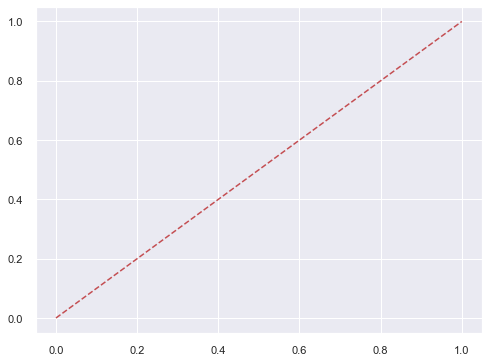

In [22]:
plt.figure(figsize=(8,6))
plt.plot([0, 1], [0, 1],'r--')

probs_svc = SVM.decision_function(X_test)
label = y_test
probs_svc = (probs_svc - probs_svc.min()) / (probs_svc.max() - probs_svc.min())

fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr, tpr, label=f'SVC, auc = {str(round(auc,3))}')

plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("AUC-ROC for two models")
plt.legend()
plt.show()

## Calibration Curve

In [ ]:
plot_calibration_curve("SVM", 1, probs_svc)

## SVM Calibration

In [ ]:
svc = SVM

platts_scaling = CalibratedClassifierCV(svc, cv=10, method='sigmoid')
platts_scaling.fit(X_train, y_train)
calibrated_probs = platts_scaling.predict_proba(X_test)[:,1]

plot_calibration_curve("SVM", 3, calibrated_probs)

In [ ]:
cross_validation(platts_scaling, X_train, y_train, 5, df, Verbose = True)

# Business Conclusions

## Final Model

In [25]:
SVM = SVC(class_weight='balanced', probability=True, random_state=42)
SVM.fit(X_train, y_train)
pickle.dump(SVM, open('../src/model.pkl', 'wb'))

In [26]:
import pickle
model = pickle.load(open('/Users/brunoschirmer/Repos/churn/src/model.pkl', 'rb'))

In [27]:
y_pred_final = model.predict(X_test)
scores('Test', y_test, y_pred_final)

,Balanced Accuracy,Precision,Recall,F1,Kappa
Test,0.79,0.52,0.76,0.62,0.49


In [28]:
X_test.head()

,credit_score,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_France,geography_Germany,geography_Spain
4163,-0.19,1,-0.37,0.70,-0.76,2,0,1,0.94,1,0,0
2674,1.13,0,-1.33,0.70,0.09,1,1,0,0.28,1,0,0
6013,-0.78,0,-0.18,0.40,-0.76,1,1,0,0.21,0,0,1
968,-0.81,0,-0.18,0.30,-0.10,1,0,0,-0.21,1,0,0
9419,0.25,0,-1.23,0.10,-0.31,1,1,1,-0.22,0,1,0


## What is TopBank's current churn rate?

In [115]:
rate = df_raw.exited.sum()/len(df_raw)*100
print('Current rate is: {:.2f}%'.format(rate))

Current rate is: 20.37%


## How does the churn rate vary monthly?

In [116]:
aux = df_raw[df_raw['is_active_member']==1]

In [126]:
monthly_rate = aux['exited'].sum()/len(aux)*100
monthly_rate

14.269073966220153

In [128]:
print('Monthly churning rate is: {:.2f}%'.format(monthly_rate))

Monthly churning rate is: 14.27%


## What is the expected return, in terms of revenue, if the company uses its model to avoid churn from customers?

In [199]:
data = df_raw.copy()
train = data.loc[:,data.columns != 'exited']
test = data.exited

In [200]:
#Dropping surname and ID columns

train = train.drop(columns=['surname','customer_id'])

# Gender Encoding
train['gender'] = train['gender'].map({'Male': 0, 'Female': 1})

#Geography encoding
train = pd.get_dummies( train, prefix=['geography'], columns=['geography'] )

#Defining scalers
rs = RobustScaler()
ss = StandardScaler()
mms = MinMaxScaler()

#Credit Score
train['credit_score'] = rs.fit_transform(train[['credit_score']].values)

#Age
train['age'] = ss.fit_transform(train[['age']].values)

#Estimated Salary
train['estimated_salary'] = rs.fit_transform(train[['estimated_salary']].values)

#Tenure
train['tenure'] = mms.fit_transform(train[['tenure']].values)

#Balance
train['balance'] = rs.fit_transform(train[['balance']].values)

train.head()

,credit_score,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_France,geography_Germany,geography_Spain
0,-0.25,1,0.29,0.20,-0.76,1,1,1,0.01,1,0,0
1,-0.33,1,0.20,0.10,-0.10,1,0,1,0.13,0,0,1
2,-1.12,1,0.29,0.80,0.49,3,1,0,0.14,1,0,0
3,0.35,1,0.01,0.10,-0.76,2,0,0,-0.06,1,0,0
4,1.48,1,0.39,0.20,0.22,1,1,1,-0.21,0,0,1


In [201]:
SVM.fit(train, test)

SVC(class_weight='balanced', probability=True, random_state=42)

In [202]:
y_pred_final = SVM.predict(train)
scores('Real Data', test, y_pred_final)

,Balanced Accuracy,Precision,Recall,F1,Kappa
Real Data,0.80,0.53,0.77,0.62,0.51


In [206]:
pred_df = df_raw.copy()
pred_df['prediction'] = y_pred_final
pred_df.head()

,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,prediction
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0


In [208]:
salary_mean = pred_df.estimated_salary.mean()

In [216]:
pred_df['retained_value'] = pred_df[(pred_df['exited'] == 1) & (pred_df['prediction'] == 1)]['estimated_salary'].apply(lambda x: 0.15*x if x <= salary_mean else 0.20*x)
pred_df['retained_value'].fillna(0, inplace=True)

In [219]:
lost_revenue = pred_df[pred_df['exited'] == 1]['estimated_salary'].apply(lambda x: 0.15*x if x <= salary_mean else 0.20*x)
retained_value = pred_df[(pred_df['exited'] == 1) & (pred_df['prediction'] == 1)]['estimated_salary'].apply(lambda x: 0.15*x if x <= salary_mean else 0.20*x) 

In [236]:
# print('Loss without any prediction would be: R$(lost_revenue.sum()))
print('Using the model, we retained R$ %.2f of R$ %.2f.' % (retained_value.sum(), lost_revenue.sum()))
print('About {:.3}% loss prevention.'.format((retained_value.sum() / lost_revenue.sum()*100)))

Using the model, we retained R$ 29974811.45 of R$ 38846324.63.
About 77.2% loss prevention.


## 3.5 What will be the churn rate using the model?

In [237]:
print('The churn rate will be {:.2}%.'.format(0.23))

The churn rate will be 0.23%.
